# Beyond Linear Regression

In our last lecture, we did a deep, "statistical" dive into Linear Regression using `statsmodels`. Our goal was **understanding** and **inference**.
* We learned to interpret coefficients ($\beta$), p-values, and $R^2$.
* We diagnosed our models using residual plots.

This process revealed two major problems with our simple models:
1.  **A "U-Shape" in our residuals:** When modeling `mpg ~ horsepower`, the residual plot showed a clear non-linear pattern. This means our model was **underfitting** (high bias) because the real-world relationship *isn't a line*.
2.  **Multicollinearity:** When we used multiple predictors (like `horsepower` and `weight`), we saw that their high correlation made their p-values unstable, confusing our interpretation.

Today, we will fix these problems by extending the linear model. In doing so, we will see that we start to lose simple interpretability. This loss will be our pivot to a new perspective: the **Machine Learning** approach, where our primary goal shifts from *understanding* to **predictive accuracy**.

## The "Statistical" Fixes: Extending the Linear Model

Let's first try to fix our model while still staying in the `statsmodels` (statistical) world.

### Interaction Terms
A simple linear model assumes the effect of each predictor on $Y$ is **additive**. The formula

$$mpg = \beta_0 + \beta_1 \text{horsepower} + \beta_2 \text{weight}$$

assumes that the effect of 1 unit of `horsepower` (which is $\beta_1$) is **constant**, regardless of the car's `weight`.

Is that true? We can test this by adding an **interaction term**:

$$mpg = \beta_0 + \beta_1 \text{horsepower} + \beta_2 \text{weight} + \beta_3 (\text{horsepower} \times \text{weight})$$

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load and clean the data (same as last lecture)
mpg = sns.load_dataset('mpg')
mpg = mpg.drop('name', axis=1)
mpg['horsepower'] = pd.to_numeric(mpg['horsepower'], errors='coerce')
mpg = mpg.dropna()

# Fit the simple additive model
model_additive = smf.ols('mpg ~ horsepower + weight', data=mpg).fit()

# Fit the new interaction model
model_interaction = smf.ols('mpg ~ horsepower + weight + horsepower * weight', data=mpg).fit()

print("--- Additive Model (R-squared) ---")
print(f"Adj. R-squared: {model_additive.rsquared_adj:.4f}")

print("\n--- Interaction Model (R-squared) ---")
print(f"Adj. R-squared: {model_interaction.rsquared_adj:.4f}")

print("\n--- Interaction Model Coefficients ---")
print(model_interaction.summary().tables[1])

--- Additive Model (R-squared) ---
Adj. R-squared: 0.7049

--- Interaction Model (R-squared) ---
Adj. R-squared: 0.7465

--- Interaction Model Coefficients ---
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            63.5579      2.343     27.127      0.000      58.951      68.164
horsepower           -0.2508      0.027     -9.195      0.000      -0.304      -0.197
weight               -0.0108      0.001    -13.921      0.000      -0.012      -0.009
horsepower:weight  5.355e-05   6.65e-06      8.054      0.000    4.05e-05    6.66e-05


### Interpreting the Interaction

Notice two things:
1.  The **Adj. R-squared** increased! This indicates the interaction model is a better fit.
2.  The p-value for the `horsepower:weight` term is tiny ($< 0.001$). This confirms the interaction is statistically significant.

But how do we interpret the coefficient for `horsepower`?
We can rewrite the formula:

$$mpg = \beta_0 + (\beta_1 + \beta_3 \times \text{weight}) \times \text{horsepower} + \beta_2 \text{weight}$$

The "effect" of `horsepower` is no longer a single number, $\beta_1$. It is now $(\beta_1 + \beta_3 \times \text{weight})$. This means the effect of `horsepower` *depends on* the `weight` of the car.

We have gained accuracy, but at the cost of simple, at-a-glance interpretability. This is the first "crack" in our "glass box" model.

Let's diagnose our residuals to see if we gained something:

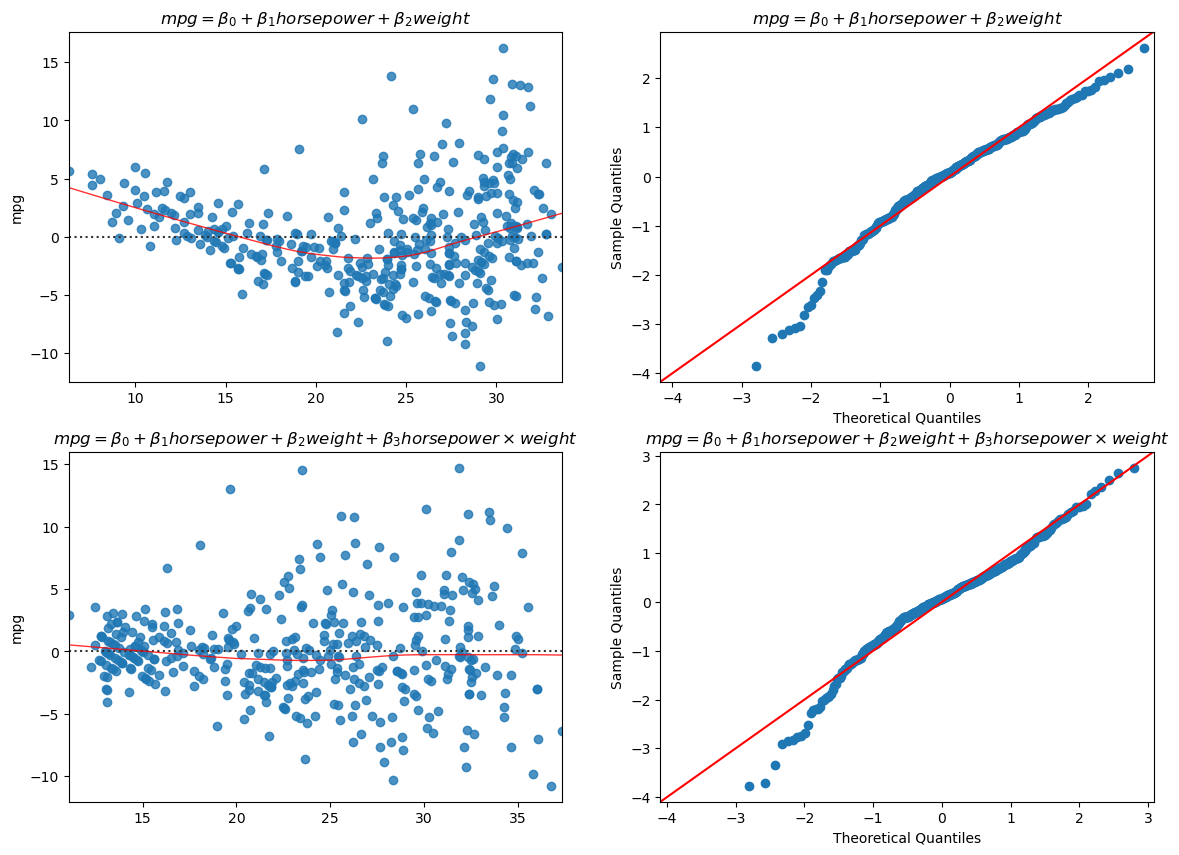

In [9]:
from statsmodels.formula.api import ols
data=mpg

plt.figure(figsize=(14,10))

fitted = ols("mpg ~ horsepower + weight", data.dropna()).fit().fittedvalues.fillna(0)
sns.residplot(x=fitted, y='mpg', data=data.dropna(),lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=plt.subplot(221))
plt.title("$mpg = \\beta_0 + \\beta_1 horsepower + \\beta_2 weight$")
sm.qqplot(fitted-data.dropna()['mpg'], line='45',fit=True, ax=plt.subplot(222))
plt.title("$mpg = \\beta_0 + \\beta_1 horsepower + \\beta_2 weight$")

fitted = ols("mpg ~ horsepower + weight + horsepower*weight", data.dropna()).fit().fittedvalues.fillna(0)
sns.residplot(x=fitted, y='mpg', data=data.dropna(),lowess=True,line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=plt.subplot(223))
plt.title("$mpg = \\beta_0 + \\beta_1 horsepower + \\beta_2 weight + \\beta_3 horsepower \\times weight$")
sm.qqplot(fitted-data.dropna()['mpg'], line='45',fit=True, ax=plt.subplot(224))
plt.title("$mpg = \\beta_0 + \\beta_1 horsepower + \\beta_2 weight + \\beta_3 horsepower \\times weight$")
plt.show()

The situation improved! We now have a better model, even if not perfect.

## Quadratic and Polynomial Regression

We will now take another route to address our nonlinear problem. Let's have a look at the relationship between `mpg` and `horsepower`:

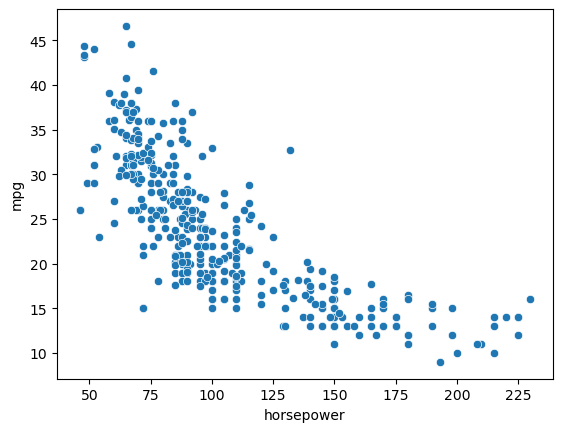

In [10]:
sns.scatterplot(x='horsepower',y='mpg',data=data)
plt.show()

This relationship does not look linear. It looks instead as a quadratic, which would be fit by the following model:

$$mpg = \beta_0 + \beta_1 horsepower + \beta_2 horsepower^2$$

Again, the model above is nonlinear in `horsepower`, but we can still fit it with a linear regressor if we add a new variable $z=horsepower^2$. 

The fit model will obtain $R^2=0.688$, larger than $R^2=608$ obtained by the base model ($mpg = \beta_0 + \beta_1 horsepower$). Both have a large F-statistic.

The estimated coefficients are:

In [11]:
ols("mpg ~ horsepower + I(horsepower**2)", data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
I(horsepower ** 2),0.0012,0.000,10.080,0.000,0.001,0.001


The coefficients now describe the quadratic:

$$y = 58.9001 - 0.4662 x + 0.0012 x^2$$

If we plot it on the data, we obtain the following:

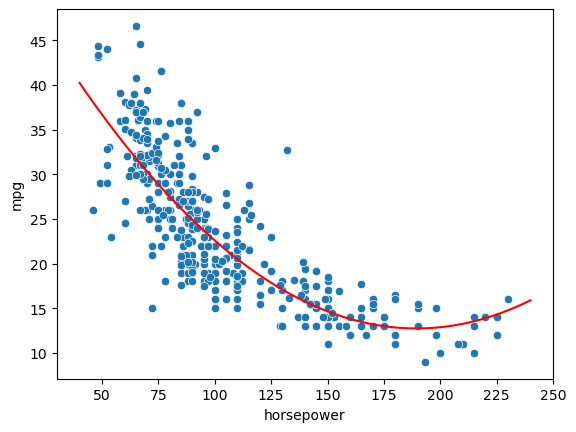

In [12]:
model=ols("mpg ~ horsepower + I(horsepower**2)", data).fit()
b0, b1, b2 = model.params.values
sns.scatterplot(x='horsepower',y='mpg',data=data)
x = np.linspace(40,240,200)
y = b0+b1*x+b2*x**2
plt.plot(x,y,'r')
plt.show()

### Polynomial Regression

In general, we can fit a polynomial model to the data, choosing a suitable degree $d$. For instance, for $d=4$ we have:

$$mpg = \beta_0 + \beta_1 horsepower + \beta_2 horsepower^2 + \beta_3 horsepower^3 + \beta_4 horsepower^4$$

which identifies the following fit:

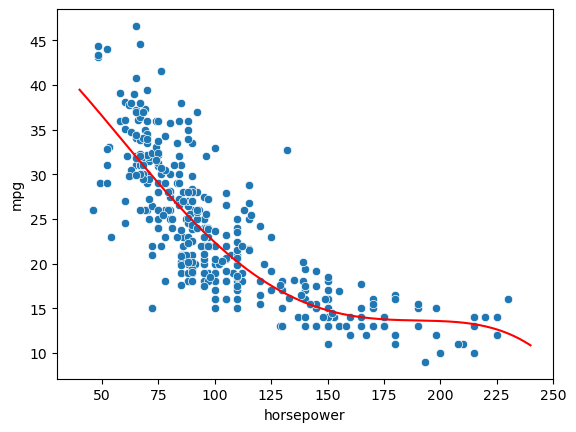

In [18]:
model=ols("mpg ~ horsepower + I(horsepower**2) + I(horsepower**3) + I(horsepower**4)", data).fit()
b0, b1, b2, b3,b4 = model.params.values
sns.scatterplot(x='horsepower',y='mpg',data=data)
x = np.linspace(40,240,200)
y = b0+b1*x+b2*x**2+b3*x**3+b4*x**4
plt.plot(x,y,'r')
plt.show()

This approach is known as **polynomial regression** and allows to turn the linear regression into a nonlinear model. Note that, when we have more variables, polynomial regression also includes interaction terms. For instance, the linear model:

$$y = \beta_0 + \beta_1x + \beta_2y$$

becomes the following polynomial model of degree $2$:

$$y = \beta_0 + \beta_1x + \beta_2y + \beta_3x^2 + \beta_4y^2 + \beta_5 xy$$

As usual, we only have to add new variables for the squared and interaction term and solve the problem as a linear regression one. This is easily handled by libraries. Note that, as the number of variables increases, the number of terms to add for a given degree also increases.

> The key observation here is that, while the polynomial regression function is **nonlinear in the variable**, it is still **linear in its coefficients**, which makes it still solvable with ordinary least squares.

## From Understanding to Prediction: The Machine Learning Perspective

The examples above show how quadratic and polynomial regressions allow to obtain **excellent fits** to the data, with improvements in terms of `Adj. R-squared` and significant p-vlaues.

Let's consider the quadratic fit in particular. The `Adj. R-squared` (0.686) is much higher than the simple linear model's (0.605). And the p-values for both `horsepower` and `I(horsepower**2)` are $< 0.001$.

This is a clear win, but at what cost?

> **We have lost all simple interpretability.**

What is the "effect" of `horsepower` on `mpg`? It's not $\beta_1$. From calculus, the effect of a 1-unit change in $X$ on $Y$ is the derivative:
$\frac{d(mpg)}{d(horsepower)} = \beta_1 + 2\beta_2 \times \text{horsepower}$

The effect is not a single number. It *depends on the value of horsepower*. We can't just look at the table and give a simple explanation.

**This is the pivot.** If we are willing to sacrifice simple, at-a-glance interpretability in exchange for a model that *fits better*... why stop here?

If our main goal is no longer *understanding* (p-values) but **predictive accuracy**, we should embrace this. We have just crossed the line from statistical inference into the realm of **Machine Learning**.



### Metrics for Prediction (Test Set Error)

When our goal is **prediction** (the ML approach), we do not care about $R^2$ or RSE on the training data. We *only* care about the model's performance on **new, unseen data** (the **Test Set**).

The following metrics are used to evaluate the model on the test set. (We will use $m$ to denote the number of samples in the test set).

#### 1. Mean Squared Error (MSE)
The MSE is the average of the squared errors on the test set. It is the "predictive" version of the $R_{emp}$ (Empirical Risk) we saw earlier.

$$MSE_{test} = \frac{1}{m}\sum_{j=1}^{m} (y_j - \hat{y}_j)^2$$

* **Interpretation:** This is an **error measure**, so a good model has a **small MSE**.
* **Problem:** The units are **squared** (e.g., if $y$ is in meters, MSE is in square-meters). This is not intuitive.

#### 2. Root Mean Squared Error (RMSE)
The RMSE is the fix for the MSE's unit problem and is the most common metric for predictive regression. It is simply the square root of the MSE.

$$RMSE_{test} = \sqrt{MSE_{test}} = \sqrt{\frac{1}{m}\sum_{j=1}^{m} (y_j - \hat{y}_j)^2}$$

* **Interpretation:** RMSE is in the **same units as $Y$** (e.g., meters). It can be read as "On average, our model's predictions on the test set are wrong by about [RMSE value]."
* **Key Property:** Because it squares errors before averaging, the RMSE **penalizes large errors** (outliers) more heavily than small errors.

#### 3. Mean Absolute Error (MAE)
The MAE is an alternative to RMSE that is also highly interpretable.

$$MAE_{test} = \frac{1}{m}\sum_{j=1}^{m} |y_j - \hat{y}_j|$$

* **Interpretation:** MAE is also in the **same units as $Y$**. It measures the "average absolute error" of the predictions.
* **Key Property:** Unlike RMSE, MAE does *not* disproportionately penalize large errors. It is **more robust to outliers**.

Let's revisit a plot we saw in our last lecture, adding prediction error measures to the picture:

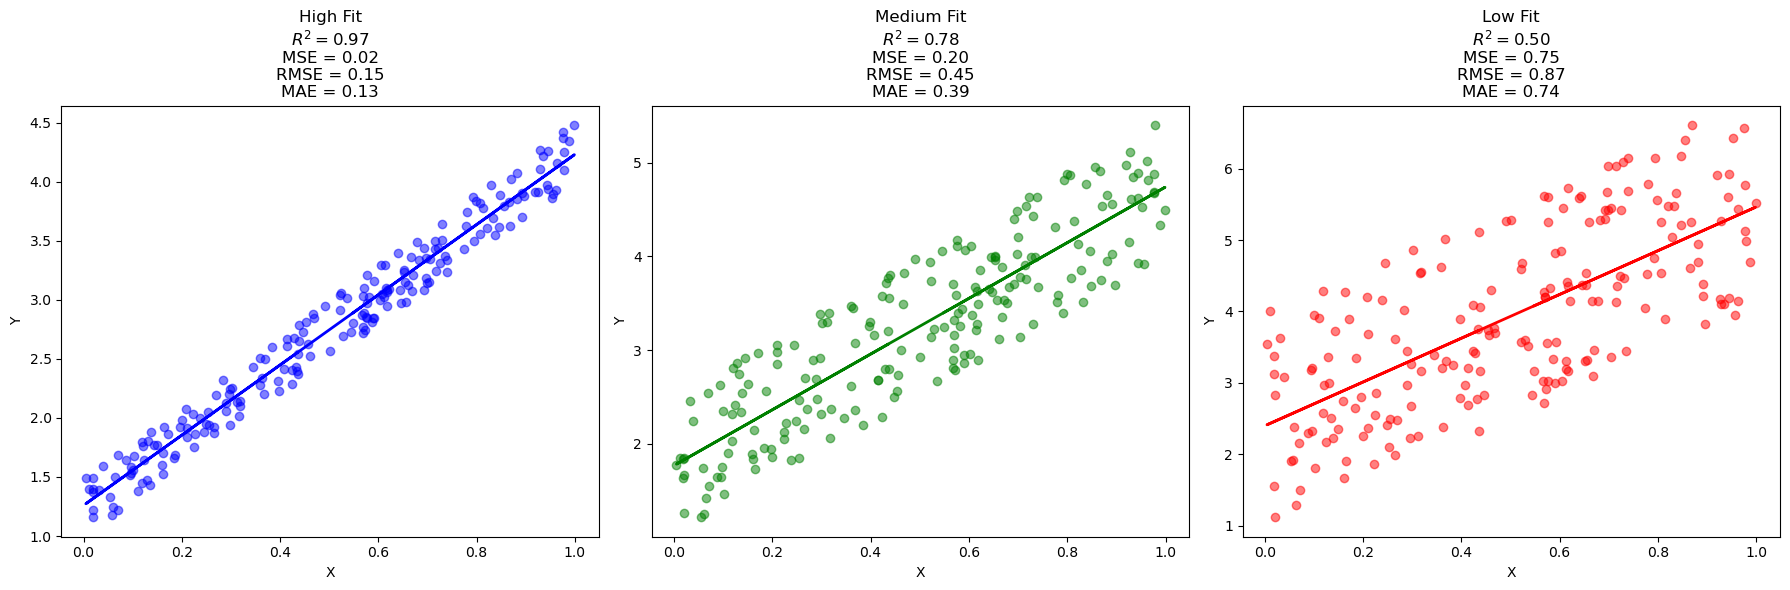

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Generate random data
np.random.seed(0)
x = np.random.rand(200, 1)

# Define noise levels
noise1 = 0.5 * np.random.rand(200, 1)
noise2 = 1.5 * np.random.rand(200, 1)
noise3 = 3.0 * np.random.rand(200, 1)

# Create y values
y1 = 3 * x + 1 + noise1  # High R-squared (low noise)
y2 = 3 * x + 1 + noise2  # Medium R-squared
y3 = 3 * x + 1 + noise3  # Low R-squared (high noise)

# 2. Fit linear regression models
reg1 = LinearRegression().fit(x, y1)
reg2 = LinearRegression().fit(x, y2)
reg3 = LinearRegression().fit(x, y3)

# 3. Get predictions
y_pred1 = reg1.predict(x)
y_pred2 = reg2.predict(x)
y_pred3 = reg3.predict(x)

# 4. Calculate all metrics
# Set 1 (High Fit)
r2_1 = r2_score(y1, y_pred1)
mse_1 = mean_squared_error(y1, y_pred1)
rmse_1 = np.sqrt(mse_1)
mae_1 = mean_absolute_error(y1, y_pred1)

# Set 2 (Medium Fit)
r2_2 = r2_score(y2, y_pred2)
mse_2 = mean_squared_error(y2, y_pred2)
rmse_2 = np.sqrt(mse_2)
mae_2 = mean_absolute_error(y2, y_pred2)

# Set 3 (Low Fit)
r2_3 = r2_score(y3, y_pred3)
mse_3 = mean_squared_error(y3, y_pred3)
rmse_3 = np.sqrt(mse_3)
mae_3 = mean_absolute_error(y3, y_pred3)

# 5. Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6)) # Made figure wider

# Helper function to create a formatted title string
def create_title(r2, mse, rmse, mae):
    # Use matplotlib's TeX rendering for R^2
    r2_str = r'$R^2 = ' + f'{r2:.2f}$'
    # Format other metrics
    mse_str = f'MSE = {mse:.2f}'
    rmse_str = f'RMSE = {rmse:.2f}'
    mae_str = f'MAE = {mae:.2f}'
    return f"{r2_str}\n{mse_str}\n{rmse_str}\n{mae_str}"

# Plot the first dataset
axes[0].scatter(x, y1, c='blue', alpha=0.5)
axes[0].plot(x, y_pred1, color='blue', linewidth=2)
axes[0].set_title(f"High Fit\n{create_title(r2_1, mse_1, rmse_1, mae_1)}", fontsize=12)
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')

# Plot the second dataset
axes[1].scatter(x, y2, c='green', alpha=0.5)
axes[1].plot(x, y_pred2, color='green', linewidth=2)
axes[1].set_title(f"Medium Fit\n{create_title(r2_2, mse_2, rmse_2, mae_2)}", fontsize=12)
axes[1].set_xlabel('X')
axes[1].set_ylabel('Y')

# Plot the third dataset
axes[2].scatter(x, y3, c='red', alpha=0.5)
axes[2].plot(x, y_pred3, color='red', linewidth=2)
axes[2].set_title(f"Low Fit\n{create_title(r2_3, mse_3, rmse_3, mae_3)}", fontsize=12)
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

plt.tight_layout()
plt.show()

## The Problem with Power: Overfitting

We've solved our underfitting problem! By adding a $horsepower^2$ term in **our quadratic regressione example**, we created a model with a **higher capacity** (more flexibility) that fits the data better.

But this creates a new, dangerous question: 

> **If $degree=2$ is good, is $degree=5$ better? What about $degree=20$?**

A high-degree polynomial model has *enormous* capacity. It can "wiggle" as much as it needs to fit every single data point. This leads to the central problem of machine learning: **overfitting**.

**Overfitting** (or **high variance**) is when a model learns the *noise* in the training data, not the underlying *signal*. It will have a fantastic $R^2$ on the data it was trained on, but will fail (generalize) miserably on any new data.

Look at the example below:

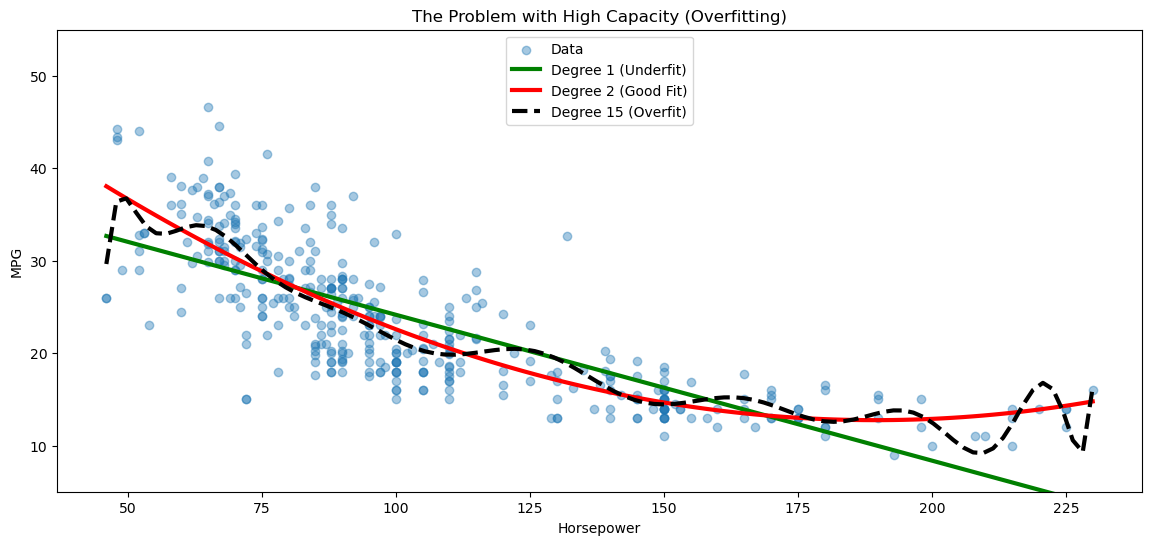

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# Load data
mpg = sns.load_dataset('mpg').dropna()
X = mpg[['horsepower']]
y = mpg['mpg']

# Create x_plot with feature name to avoid warnings
x_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
x_plot_df = pd.DataFrame(x_plot, columns=['horsepower'])

# Plot setup
plt.figure(figsize=(14, 6))
plt.scatter(X, y, alpha=0.4, label='Data')

# Degree 1 (Underfit)
model_lin = LinearRegression()
model_lin.fit(X, y)
y_plot_lin = model_lin.predict(x_plot_df)
plt.plot(x_plot_df, y_plot_lin, 'g', lw=3, label='Degree 1 (Underfit)')

# Degree 2 (Good Fit)
pipe_quad = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('model', LinearRegression())
])
pipe_quad.fit(X, y)
y_plot_quad = pipe_quad.predict(x_plot_df)
plt.plot(x_plot_df, y_plot_quad, 'r', lw=3, label='Degree 2 (Good Fit)')

# Degree 15 (Overfit)
pipe_overfit = Pipeline([
    ('poly', PolynomialFeatures(degree=15, include_bias=False)),
    ('scaler', StandardScaler()),  # Scaling is critical for high-degree polys
    ('model', LinearRegression())
])
pipe_overfit.fit(X, y)
y_plot_overfit = pipe_overfit.predict(x_plot_df)
plt.plot(x_plot_df, y_plot_overfit, 'k--', lw=3, label='Degree 15 (Overfit)')

# Final plot settings
plt.legend(loc='upper center')
plt.title('The Problem with High Capacity (Overfitting)')
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.ylim(5, 55)
plt.show()

We can see that, while the linear model is clearly **underfitting**, the high-degree polynomial is **overfitting**! The quadratic model seems to be in the sweet spot, but how shall we find the correct degree in a systematic way?

### The Solution: Regularization

The plot above shows our dilemma: the $degree=15$ model is "too powerful." How can we use a high-capacity model *without* it overfitting?

Unfortunately, as the model becomes complex, it's not straightforward to use plain statistics to answer this question.

Instead, following a pure machine learning perspective, we will use a technique called **regularization**.

**Regularization adds a "penalty"** to the cost function to *discourage* the model from becoming too complex.

Instead of just minimizing $RSS$, we minimize 

$$RSS + \text{Penalty Term}$$

This penalty term is designed to **force the $\beta$ coefficients to stay small**. A "wiggly" (overfit) curve *requires* massive $\beta$ coefficients. By penalizing large coefficients, we force the model to find a *simpler, smoother* curve, even if it has many features.

#### Revisiting Collinearity
Regularization also happens to be a fantastic solution to our *other* major problem: **multicollinearity**.

As we saw, when predictors like `horsepower` and `weight` are highly correlated, the $X^T X$ matrix is ill-conditioned, and the OLS coefficient estimates become **unstable** and their standard errors explode.

Regularization "stabilizes" this matrix, allowing the model to find sensible, stable coefficients even in the presence of multicollinearity.

### Ridge Regression (L2 Penalty)

Ridge Regression is the most common type of regularization. It adds a penalty proportional to the **sum of the squares of the coefficients**. This is also called the **$L_2$ norm**.

The cost function becomes:
$$RSS_{L2} = \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n \beta_j^2$$

* The $RSS$ term pushes the model to **fit the data** (reducing bias).
* The $\lambda \sum \beta_j^2$ term pushes the coefficients to be **small** (reducing variance).

The **hyperparameter $\lambda$** (called `alpha` in code) controls this tradeoff.
* **$\lambda = 0$**: This is just standard OLS.
* **$\lambda \to \infty$**: The penalty is everything. All coefficients are forced to zero (a flat line).

**Key Property:** Ridge Regression *shrinks* coefficients close to zero, but **it will not set them *exactly* to zero**.

**Crucial Step:** Because the penalty $\sum \beta_j^2$ is based on the *size* of the coefficients, it is critical that we **standardize (z-score)** all our features first. Otherwise, a feature measured in kilometers will be penalized differently than one measured in millimeters.

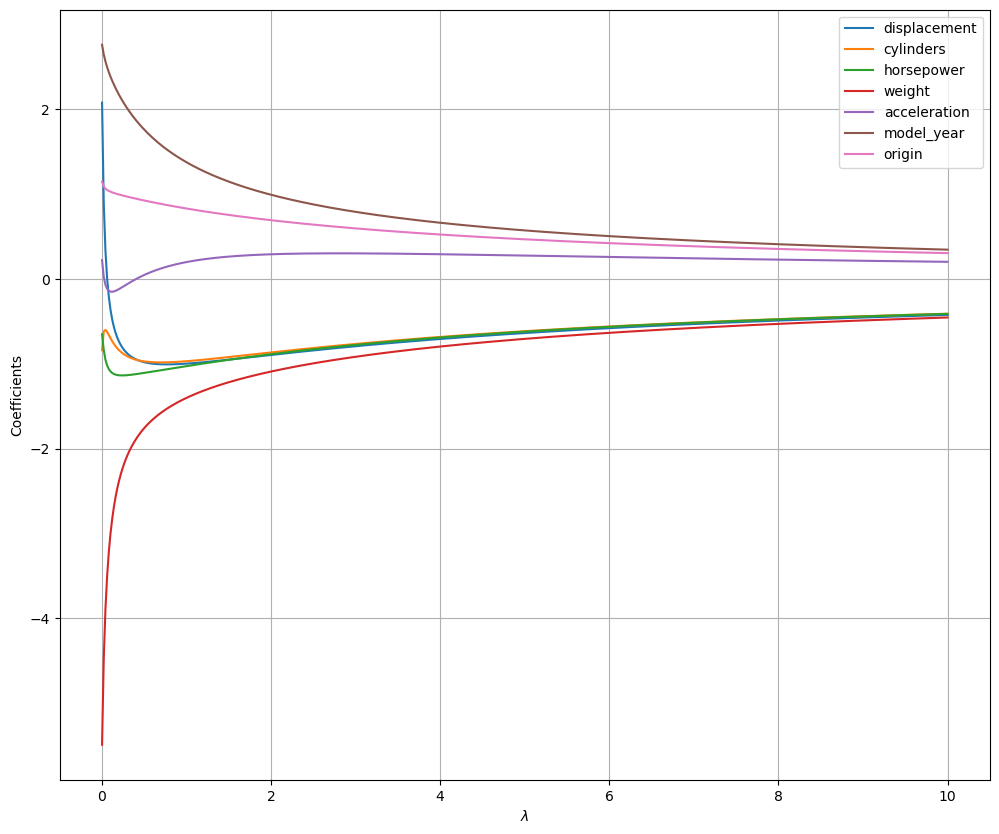

In [26]:
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 
from statsmodels.formula.api import ols
import pandas as pd
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
data = X.join(y)

data2=data.dropna().drop('mpg',axis=1).apply(zscore).join(data.dropna()['mpg'])
dd=[]
for alpha in np.linspace(0,10,500):
    d=ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data2).fit_regularized(L1_wt=0, alpha=alpha).params

    
    d= pd.Series(
        {
            c:v for c,v in zip(["Intercept","displacement", "cylinders", "horsepower" ,"weight" ,"acceleration", "model_year" ,"origin"],d)
        }
        )
    d['alpha']=alpha
    dd.append(d)
dd=pd.concat(dd,axis=1).T
dd.drop('Intercept',axis=1).plot(x='alpha', figsize=(12,10))
plt.xlabel("$\lambda$")
plt.ylabel("Coefficients")
plt.grid()

As you can see, as $\lambda$ increases, all coefficients are smoothly "shrunk" toward zero. Interestingly, the model **"decides"** which coefficients to shrink for a given value of $\lambda$. For instance, for low values of $\lambda$, `weight` is shrunk, while `acceleration` is first shrunk, then allowed to be larger than zero. This is due to the fact that, the regularization term acts as a sort of "soft constraint" encouraging the model to find smaller weights, while still finding a good solution.

It can be shown (but we will not see it formally), that ridge regression **reduces the variance of coefficient estimates**. At the same time, **the bias is increased**. So, finding a good value of $\lambda$ allows to **control the bias-variance trade-off**.

#### Interpretation of the ridge regression coefficients
Let us compare the parameters obtained through a ridge regressor with those obtained with a linear regressor (OLS):

In [27]:
params = pd.DataFrame({'variables':['displacement','cylinders' , 'horsepower' , 'weight' , 'acceleration' , 'model_year' , 'origin'], 'ridge_params':ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data2).fit_regularized(L1_wt=0, alpha=1).params[1:],'ols_params':ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data2).fit().params[1:]}).set_index('variables')
params

,ridge_params,ols_params
variables,,
displacement,-0.998445,2.079303
cylinders,-0.969852,-0.840519
horsepower,-1.027231,-0.651636
weight,-1.401530,-5.492050
acceleration,0.199621,0.222014
model_year,1.375600,2.762119
origin,0.830411,1.147316


As we can see, the ridge parameters has a smaller scale. This is due to the regularization term. As a result, the parameters **cannot be interpreted statistically as the ones of a linear regressor**. Instead, we can interpret them as denoting the relative importance of the variable to the prediction.

### Lasso Regression ($L_1$ Penalty)

Lasso is an alternative that has a different, very useful property. It adds a penalty proportional to the **sum of the absolute values of the coefficients**. This is also called the **$L_1$ norm**.

The cost function becomes:

$$RSS_{L1} = \sum_{i=1}^m (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^n |\beta_j|$$

This subtle change has a profound effect. The "sharp corners" of the absolute value function allow the optimization to find solutions where "useless" coefficients are set to **exactly zero**.

**Its Superpower:** Lasso performs **automatic feature selection**, which is great when you have hundreds of features.

The figure below shows how the coefficient estimates change for different values of $\lambda$:


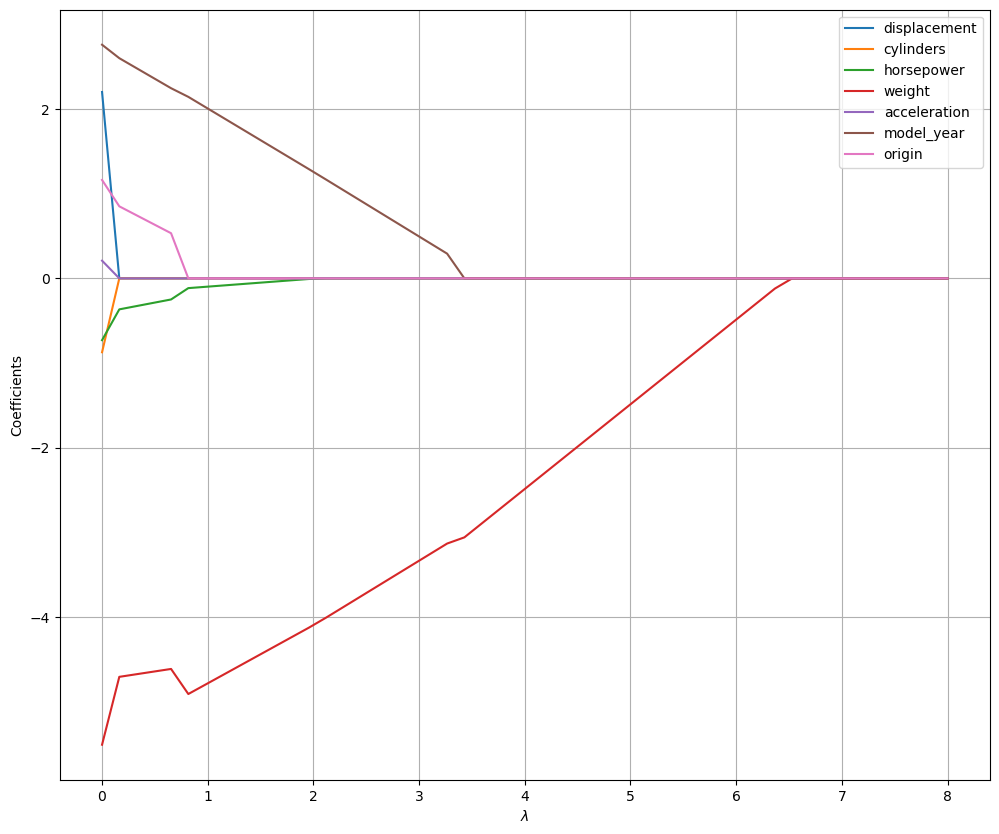

In [28]:
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo 
from statsmodels.formula.api import ols
import pandas as pd
  
# fetch dataset 
auto_mpg = fetch_ucirepo(id=9) 
  
# data (as pandas dataframes) 
X = auto_mpg.data.features 
y = auto_mpg.data.targets 
  
data = X.join(y)

data2=data.dropna().drop('mpg',axis=1).apply(zscore).join(data.dropna()['mpg'])
dd=[]
for alpha in np.linspace(0,8,50):
    d=ols("mpg ~ displacement + cylinders + horsepower + weight + acceleration + model_year + origin", data2).fit_regularized(L1_wt=1, alpha=alpha).params

    
    d= pd.Series(
        {
            c:v for c,v in zip(["Intercept","displacement", "cylinders", "horsepower" ,"weight" ,"acceleration", "model_year" ,"origin"],d)
        }
        )
    d['alpha']=alpha
    dd.append(d)
dd=pd.concat(dd,axis=1).T
dd.drop('Intercept',axis=1).plot(x='alpha', figsize=(12,10))
plt.xlabel("$\lambda$")
plt.ylabel("Coefficients")
plt.grid()

As can be seen, the model now makes "hard choices" on whether a value should be set to zero or not, thus performing variable selection. Once Lasso regression identified the variables to remove, we could create a reduced dataset keeping only columns with nonzero coefficients and fit a regular, interpretable, linear regressor with the original, non standardized, data.

### Regularization and the Bias-Variance Tradeoff

Regularization is our first, and most powerful, tool for **explicitly managing the Bias-Variance Tradeoff**.

Let's think about the two extremes:

1.  **A Standard OLS Model (or high-degree polynomial)**
    * This model's only goal is to **minimize $RSS$**.
    * It will "succeed" by fitting the training data perfectly, including all its noise.
    * This results in a model with **$\text{Low Bias}$** (it's a perfect fit for the data it saw) but **$\text{Extremely High Variance}$** (it's "nervous" and will fail on new data). This is **overfitting**.

2.  **A Regularized Model (Ridge or Lasso)**
    * This model has a *different* goal: minimize $RSS + \text{Penalty Term}$.
    * To get the lowest total score, it is *forced* to make a compromise. It will *intentionally* stop fitting the training data perfectly, in order to make its coefficients smaller and reduce the penalty.
    * This is the trade-off in action:
        * We **increase the bias** slightly (because our model is now "imperfect" for the training data).
        * In exchange, we **dramatically decrease the variance** (because the model is smoother and no longer chasing noise).

### $\lambda$ is the "Tradeoff Knob"

The **hyperparameter $\lambda$** (called `alpha` in `scikit-learn`) is our **explicit control knob** for moving along the bias-variance curve.

* **When $\lambda = 0$:** We are on the far right of the graph. We have a standard OLS model with $\text{Low Bias}$ and $\text{High Variance}$ (overfitting).
* **As we increase $\lambda$:** We "turn the knob," increasing the penalty. This moves us left on the graph. $\text{Bias}$ starts to go up, but $\text{Variance}$ drops *faster*. The **Total Error** (the black line) goes down.
* **At the "sweet spot":** We find the optimal $\lambda$ that gives us the lowest possible **Total Error**.
* **As $\lambda \to \infty$:** We move to the far left of the graph. We are penalizing the coefficients so much that they all become zero (a flat line). The model has $\text{High Bias}$ and $\text{Low Variance}$ (underfitting).

The *entire goal* of the machine learning workflow, which we are about to see, is to find the **optimal value of $\lambda$**. We can't use our `statsmodels` p-values for this. We must use a new technique, **cross-validation**, to find the $\lambda$ that gives the best predictive score on unseen data.

The plot below shows how training and validation error change when fitting a polynomial of degree $15$ (a high-capacity model) as we increase the regularization hyperparameter $\lambda$, which illustrates how **regularization controls the bias-variance trade-off**.

Validation curve plot saved as 'validation_curve.png'


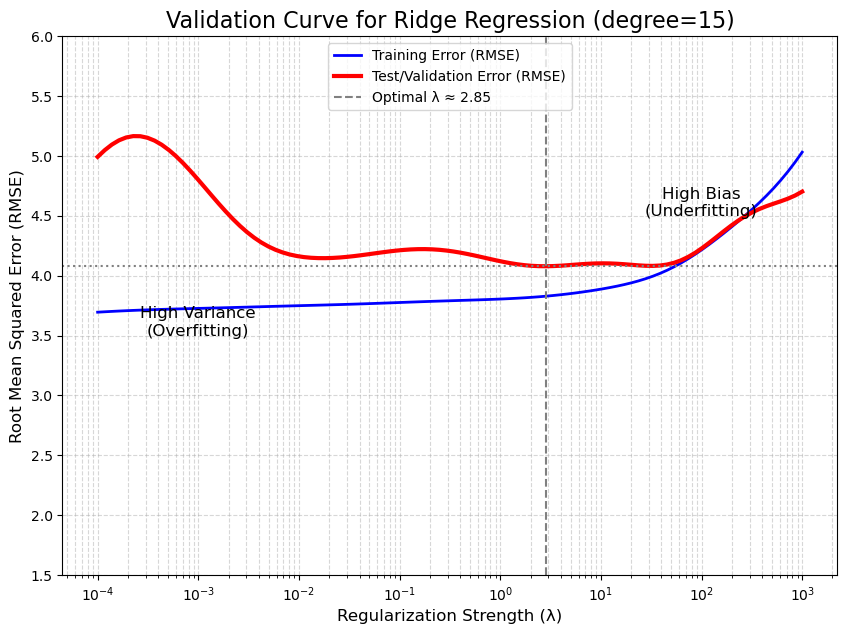

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# 1. Load and prep data
mpg = sns.load_dataset('mpg').dropna()

# We'll use horsepower and weight to predict mpg
y = mpg['mpg']
X = mpg[['horsepower', 'weight']]

# 2. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Create a list of alphas (λ values) to test
# We use np.logspace to get a range from 10^-4 to 10^3
alphas = np.logspace(-4, 3, 100)

# 4. Create lists to store the errors
train_errors = []
test_errors = []

# 5. Loop over all alphas
for a in alphas:
    # 5a. Create the full pipeline
    # We use a 4th-degree polynomial to force overfitting
    pipe = Pipeline([
        ('poly', PolynomialFeatures(degree=15, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=a, max_iter=10000)) # 'alpha' is our λ
    ])
    
    # 5b. Fit the pipeline on the training data
    pipe.fit(X_train, y_train)
    
    # 5c. Get predictions on BOTH sets
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # 5d. Calculate and store RMSE
    train_errors.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_errors.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# --- 6. Plot the Validation Curve ---
plt.figure(figsize=(10, 7))

# Plot Training Error
plt.plot(alphas, train_errors, 'b-', lw=2, label='Training Error (RMSE)')

# Plot Test Error
plt.plot(alphas, test_errors, 'r-', lw=3, label='Test/Validation Error (RMSE)')

# Set x-axis to log scale to see the effect of all alphas
plt.xscale('log')

# Find the alpha that gave the minimum test error
optimal_alpha_idx = np.argmin(test_errors)
optimal_alpha = alphas[optimal_alpha_idx]
min_test_error = test_errors[optimal_alpha_idx]

# Mark the "sweet spot"
plt.axvline(optimal_alpha, linestyle='--', color='gray', 
            label=f'Optimal λ ≈ {optimal_alpha:.2f}')
plt.axhline(min_test_error, linestyle=':', color='gray')

# Add labels for the "High Variance" and "High Bias" regions
plt.text(1e-3, 3.5, 'High Variance\n(Overfitting)', ha='center', fontsize=12)
plt.text(1e2, 4.5, 'High Bias\n(Underfitting)', ha='center', fontsize=12)

plt.title('Validation Curve for Ridge Regression (degree=15)', fontsize=16)
plt.xlabel('Regularization Strength (λ)', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.legend(loc='upper center', fontsize=10)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.ylim(1.5, 6) # Adjust y-axis to zoom in on the curves

plt.savefig('validation_curve.png')
print("Validation curve plot saved as 'validation_curve.png'")
plt.show()

Let's see how to interpret the plot:

* **Left Side (λ is tiny, e.g., 0.001):**
    * The **Training Error** (blue) is very low. The model is *overfitting* the training data.
    * The **Test Error** (red) is high. The model is *not generalizing* well.
    * This is the **High Variance** region.

* **Right Side (λ is large, e.g., 1000):**
    * The **Training Error** is high and almost equal to the test error. The model is *too simple* (too penalized).
    * The **Test Error** is also high.
    * This is the **High Bias** region (underfitting).

* **The "Sweet Spot" (Dashed Line):**
    * This is the **optimal $\lambda$** (our optimal $\lambda$).
    * It's the "Goldilocks" point where the Test Error is at its minimum.
    * This is the perfect balance between bias and variance, giving us the best possible predictive model.

## From Theory to Practice: The `scikit-learn` Workflow

We have now established all the theory.
1.  **Our Problem:** Simple linear models can **underfit** (high bias), like the "U-shape" in our `mpg ~ horsepower` plot.
2.  **A Solution:** We can use **Polynomial Regression** to add non-linear features ($X^2, X^3, \ldots$) which gives our model higher **capacity** to fit the curve.
3.  **The New Problem:** High-capacity models can easily **overfit** (high variance), "memorizing" the training data noise.
4.  **A Better Solution:** We use **Regularization (Ridge $L_2$ or Lasso $L_1$)** to add a penalty ($\lambda$) that controls this high capacity, finding the "sweet spot" in the Bias-Variance tradeoff.

We've seen the *theory* of $\lambda$. Now we need a practical, robust workflow to actually *find* the best $\lambda$ and build the best predictive model.

It's time to switch from `statsmodels` (built for **inference**) to `scikit-learn` (built for **prediction**).

### Our New Toolkit
Our new workflow requires new rules and tools:

1.  **Train/Test Split:** This is the **Golden Rule**. We *must* split our data to simulate a "future" test set. Our only goal is to get the best score (e.g., $RMSE$) on this test data.
2.  **Standardization:** We *must* scale our features (e.g., `StandardScaler`) so the regularization penalty $\lambda$ affects them all fairly.
3.  **Pipelines:** We must bundle our steps (scaling, polynomial features, model) together. This is a best practice that prevents "data leakage" and makes our workflow reproducible.

### Dataset
We'll use the California Housing dataset provided by the `scikit-learn` library. Let us load the data as a dataframe and have a look at the data description:

In [52]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing(as_frame=True)
print(data['DESCR'])
data['data']

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


The dataset contains $8$ variables. The independent variable is `MedInc`, the average value of houses in a given suburb, while all other variables are independent. For our aims, we will treat the data as a matrix of numerical variables. We could easily convert the dataframe in this format, but scikit-learn allows to load the data directly in this format:

In [53]:
# let us load the data without passing as_frame=True
data = fetch_california_housing()
X = data.data # the features
y = data.target # the targets

print(X.shape, y.shape)

(20640, 8) (20640,)


### Data Splitting
We will split the dataset into a training, a validation and a test set using the `train_test_split` function:

In [54]:
from sklearn.model_selection import train_test_split
# We'll do a 60:20:20 split
val_prop = 0.2
test_prop = 0.2

# We'll split the data in two steps - first let's create a test set and a combined trainval set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

# We'll now split the combined trainval into train and val set with the chosen proportions
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=test_prop/(1-test_prop), random_state=42)

# Let us check shapes and proportions
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

(12384, 8) (4128, 8) (4128, 8)
0.6 0.2 0.2


The `train_test_split` function will split the data randomly. We are passing a fixed `random_state` to be able to replicate the results, but, in general, we should avoid that if we want the split to be truly random (though it is common to use random seeds for splitting in research). Note that, while the split is random, the function makes sure that the i-th element of the y variable corresponds to the i-th element of the X variable after the split.

We will now reason mainly on the validation set, comparing different models and parameter configurations. Once we are done with our explorations, we'll check the final results on the test set.

### Data Normalization
We'll start by normalizing the data with z-scoring. This will prove useful later when we use certain algorithms (e.g., regularization). Note that we have not normalized data before because we need to **make sure that even mean and standard deviation parameters are not computed on the validation or test set**. While this may seem a trivial detail, it is important to follow this rule as strictly as possible to avoid bias. We can normalize the data with the `StandardScaler` object:

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) # tunes the internal parameters of the standard scaler

X_train = scaler.transform(X_train) # does not tune the parameters anymore
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Scikit-learn objects have a unified object-oriented interface. Each algorithm is an object (e.g., `StandardScaler`) with standard methods, such as:
 * A `fit` method to tune the internal parameters of the algorithm. In this case, it is a vector of means and a vector of standard deviations, but in the case of a linear regression it will be a vector of weights;
 * A `transform` method to transform the data. Note that in this stage no parameters are tuned, so we can safely apply this method to validation and test data. This method only applies to objects which transform the data, such as the standard scaler;
 * A `predict` method to obtain predictions. This applies only to predictive models, such as a linear regressor;
 * A `score` method to obtain a standard performance measure on the test or validation data. Also this only applies to predictive models.

We will see examples of the last two methods later.

### Linear Regressor

We will start by training a linear regressor. We will use scikit-learn's implementation which does not provide statistical details (e.g., p-values) but is optimized for predictive modeling. The train/test interface is the same as above:

In [56]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train) # this tunes the internal parameters of the model

# Let us print the model's parameters
print(linear_regressor.coef_) 
print(linear_regressor.intercept_)

[ 0.86025287  0.1200073  -0.28039183  0.31208687 -0.00957447 -0.02615781
 -0.88821331 -0.86190739]
2.0680774192504314


We can obtain predictions on the validation set using the `predict` method:

In [57]:
y_val_pred = linear_regressor.predict(X_val)
print(y_val_pred.shape)

(4128,)


The function returns a vector of $4128$ predictions, one for each example in the validation set. We can now evaluate the predictions using regression evaluation measures. We will use the standard implementation of the main evaluation measures as provided by scikit-learn:

In [59]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)

print(mae, mse, rmse)

0.5333346447415042 0.5297481095803488 0.727837969317587


All evaluation measures in scikit-learn follow the `evaluation_measure(y_true, y_pred)` convention. Note that the target variable `MedInc` is measured in tens of thousands of dollars, so an MAE of about $0.5$ corresponds to an average error of about $5000$ dollars. This is not that bad if we consider the mean and standard deviation of targets:

In [60]:
y_train.mean(), y_train.std()

(np.float64(2.068077419250646), np.float64(1.1509151433486544))

Each predictor in scikit-learn also provides a `score` method which takes as input the validation (or test) inputs and outputs and computes some standard evaluation measures. By default the linear regressor in scikit-learn returns the $R^2$ value:

In [61]:
linear_regressor.score(X_val, y_val)

0.6142000785497264

While we are mainly interested in the performance of the model on the validation set (and ultimately on those on the test set), it is still useful to assess the performance on the training set for model diagnostics. For instance, if we see a big discrepancy between training and validation errors, then we can imagine that some overfitting is going on:

In [63]:
y_train_pred = linear_regressor.predict(X_train)

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)

print(mae_train, mse_train, rmse_train)

0.5266487515751342 0.5143795055231385 0.7172025554354491


We can see that, while there are some differences between training and test performance, those are minor, so we can deduce that there is no significant overfitting going on.

> We should note that we should **always expect a certain degree of overfitting, depending on the task, the data and the model**. When the difference between train and test error is large, and hence there is significant overfitting, we can try to reduce this effect with regularization techniques.

To better compare models, we will now store the results of our analyses in a dataframe:

In [64]:
import pandas as pd
california_housing_val_results = pd.DataFrame({
    'Method': ['Linear Regressor'],
    'Parameters': [''],
    'MAE': [mae],
    'MSE': [mse],
    'RMSE': [rmse]
})

california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838


It is common to use the word "method" to refer to a predictive algorithm or pipeline.

### Non-Linear Regression
Let us now try to fit a non-linear regressor. We will use polynomial regression with different polynomial degrees. To do so, we will perform an explicit polynomial expansion of the features using the `PolynomialFeatures` object. For convenience, we will define a function performing training and validation and returning both training and validation performance:

In [67]:
from sklearn.preprocessing import PolynomialFeatures
def trainval_polynomial(degree):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = LinearRegression() # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_poly_train_pred))

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_poly_val_pred))

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

Let us now see what happens with different degrees:

In [68]:
for d in range(1,4):
    print("DEGREE: {} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(d,"MAE", "MSE", "RMSE", *trainval_polynomial(d)))

DEGREE: 1 
           MAE      MSE     RMSE
TRAIN     0.53     0.51     0.72 
VAL       0.53     0.53     0.73


DEGREE: 2 
           MAE      MSE     RMSE
TRAIN     0.46     0.42     0.65 
VAL       0.48     0.91     0.95


DEGREE: 3 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      23.48 2157650.15  1468.89




### Ridge Regularization
We can see that, as the polynomial gets larger, the effect of overfitting increases. We can try to reduce this effect with Ridge or Lasso regularization. We'll focus on degree $2$ and try to apply ridge regression to it. Since Ridge regression relies on a parameter, we will try some values of the regularization parameter $\alpha$ (as it is called by sklearn). Let us define a function for convenience:

In [71]:
from sklearn.linear_model import Ridge
def trainval_polynomial_ridge(degree, alpha):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = Ridge(alpha=alpha) # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_poly_train_pred))

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_poly_val_pred))

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

Let us now see the results for different values of $\alpha$. $\alpha=0$ means no regularization:

In [72]:
print("RIDGE, DEGREE: 2")
for alpha in [0,100,200,300,400]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_ridge(2,alpha)))

RIDGE, DEGREE: 2
Alpha: 0.00 
           MAE      MSE     RMSE
TRAIN     0.46     0.42     0.65 
VAL       0.48     0.91     0.96


Alpha: 100.00 
           MAE      MSE     RMSE
TRAIN     0.47     0.43     0.66 
VAL       0.48     0.54     0.74


Alpha: 200.00 
           MAE      MSE     RMSE
TRAIN     0.48     0.44     0.67 
VAL       0.49     0.51     0.72


Alpha: 300.00 
           MAE      MSE     RMSE
TRAIN     0.49     0.46     0.68 
VAL       0.50     0.50     0.71


Alpha: 400.00 
           MAE      MSE     RMSE
TRAIN     0.50     0.47     0.68 
VAL       0.51     0.51     0.71




We can see how, as alpha increases, the error on the training set increases, while the error on the test set decreases. For $\alpha=300$ we obtained a slightly better result than our linear regressor: 

In [73]:
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838


Let us see if we can improve the results with a polynomial of degree 3:

In [74]:
print("RIDGE, DEGREE: 3")
for alpha in [0,1,10,20]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_ridge(3,alpha)))

RIDGE, DEGREE: 3


Alpha: 0.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      23.50 2162209.37  1470.45


Alpha: 1.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.58 
VAL      15.59 934580.09   966.74


Alpha: 10.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.34     0.59 
VAL       1.57  4867.65    69.77


Alpha: 20.00 
           MAE      MSE     RMSE
TRAIN     0.42     0.35     0.59 
VAL       1.78  6690.78    81.80




Let us add the results of Polynomial regression of degree 2 with and without regularization:

In [75]:
poly2 = trainval_polynomial_ridge(2,0)
poly2_ridge300 = trainval_polynomial_ridge(2,300)
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Polynomial Regressor', 'Parameters': 'degree=2', 'MAE':poly2[-3], 'MSE':poly2[-2], 'RMSE':poly2[-1]}, index=[1]),
    pd.DataFrame({'Method':'Polynomial Ridge Regressor', 'Parameters': 'degree=2, alpha=300', 'MAE':poly2_ridge300[-3], 'MSE':poly2_ridge300[-2], 'RMSE':poly2_ridge300[-1]}, index=[2])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480437,0.912971,0.955495
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039


## Lasso Regression
Let us now try the same with Lasso regression:

In [76]:
from sklearn.linear_model import Lasso
def trainval_polynomial_lasso(degree, alpha):
    pf = PolynomialFeatures(degree)
    # While the model does not have any learnable parameters, the "fit" method here is used to compute the output number of features
    pf.fit(X_train)
    X_train_poly = pf.transform(X_train)
    X_val_poly = pf.transform(X_val)

    polyreg = Lasso(alpha=alpha) # a Polynomial regressor is simply a linear regressor using polynomial features
    polyreg.fit(X_train_poly, y_train)

    y_poly_train_pred = polyreg.predict(X_train_poly)
    y_poly_val_pred = polyreg.predict(X_val_poly)

    mae_train = mean_absolute_error(y_train, y_poly_train_pred)
    mse_train = mean_squared_error(y_train, y_poly_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_poly_train_pred))

    mae_val = mean_absolute_error(y_val, y_poly_val_pred)
    mse_val = mean_squared_error(y_val, y_poly_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_poly_val_pred))

    return mae_train, mse_train, rmse_train, mae_val, mse_val, rmse_val

In [77]:
print("LSSO, DEGREE: 2")
for alpha in [0.02,0.03,0.04,0.05, 0.06]:
    print("Alpha: {:0.2f} \n      {:>8s} {:>8s} {:>8s}\nTRAIN {:8.2f} {:8.2f} {:8.2f} \nVAL   {:8.2f} {:8.2f} {:8.2f}\n\n".format(alpha,"MAE", "MSE", "RMSE", *trainval_polynomial_lasso(2,alpha)))

LSSO, DEGREE: 2
Alpha: 0.02 
           MAE      MSE     RMSE
TRAIN     0.52     0.51     0.71 
VAL       0.54     1.19     1.09


Alpha: 0.03 
           MAE      MSE     RMSE
TRAIN     0.55     0.55     0.74 
VAL       0.55     0.59     0.77


Alpha: 0.04 
           MAE      MSE     RMSE
TRAIN     0.56     0.57     0.76 
VAL       0.57     0.59     0.77


Alpha: 0.05 
           MAE      MSE     RMSE
TRAIN     0.58     0.60     0.78 
VAL       0.58     0.61     0.78


Alpha: 0.06 
           MAE      MSE     RMSE
TRAIN     0.60     0.63     0.80 
VAL       0.60     0.64     0.80




Lasso regression does not seem to improve results. Let us put the results obtained for $\alpha=0.04$ to the dataframe:

In [78]:
poly2_lasso004 = trainval_polynomial_lasso(2,0.04)
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Polynomial Lasso Regressor', 'Parameters': 'degree=2, alpha=0.04', 'MAE':poly2_lasso004[-3], 'MSE':poly2_lasso004[-2], 'RMSE':poly2_lasso004[-1]}, index=[3])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480437,0.912971,0.955495
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180


### Grid Search

Polynomial regression and ridge regression have parameters to optimize. We have so far optimized them manually. However, in practice, it is common to perform a grid search. This consists in defining a grid of possible values to try and train/validate many models, to finally choose the one with best performance.

This can be done manually as shown in the following example:

In [79]:
def grid_search(alphas=range(200,400,25), degrees=range(5)):
    best_mse = np.inf
    for a in alphas:
        for d in degrees:
            print(f"Evaluating a={a} d={d} MSE=", end='')
            results = trainval_polynomial_ridge(d,a)
            mse = results[-2]
            print(f"{mse:0.2f}")
            if mse<best_mse:
                best_mse = mse
                best_alpha = a
                best_degree = d

    return best_mse, best_alpha, best_degree
grid_search()

Evaluating a=200 d=0 MSE=1.37
Evaluating a=200 d=1 MSE=0.53
Evaluating a=200 d=2 MSE=0.51
Evaluating a=200 d=3 MSE=8161.95
Evaluating a=200 d=4 MSE=10884077.30
Evaluating a=225 d=0 MSE=1.37
Evaluating a=225 d=1 MSE=0.53
Evaluating a=225 d=2 MSE=0.51
Evaluating a=225 d=3 MSE=6710.18
Evaluating a=225 d=4 MSE=7244148.24
Evaluating a=250 d=0 MSE=1.37
Evaluating a=250 d=1 MSE=0.53
Evaluating a=250 d=2 MSE=0.51
Evaluating a=250 d=3 MSE=5542.92
Evaluating a=250 d=4 MSE=4880760.89
Evaluating a=275 d=0 MSE=1.37
Evaluating a=275 d=1 MSE=0.53
Evaluating a=275 d=2 MSE=0.50
Evaluating a=275 d=3 MSE=4598.99
Evaluating a=275 d=4 MSE=3313061.38
Evaluating a=300 d=0 MSE=1.37
Evaluating a=300 d=1 MSE=0.54
Evaluating a=300 d=2 MSE=0.50
Evaluating a=300 d=3 MSE=3831.00
Evaluating a=300 d=4 MSE=2255992.93
Evaluating a=325 d=0 MSE=1.37
Evaluating a=325 d=1 MSE=0.54
Evaluating a=325 d=2 MSE=0.50
Evaluating a=325 d=3 MSE=3202.40
Evaluating a=325 d=4 MSE=1534656.15
Evaluating a=350 d=0 MSE=1.37
Evaluating a=35

(0.5041553563051195, 300, 2)

Testing a range of values, we found that best results are obtained with degree equal to $2$ and $\alpha=300$.

### Scikit-Learn Pipelines
Often, a predictive model is obtained by stacking different components. For instance, in our example, a Polynomial regressor is obtained by following this pipeline:
* Data standardization;
* Polynomial feature expansion:
* Ridge regression.

While these steps can be carried out independently as seen before, scikit-learn offers the  powerful interface of `Pipelines` to automate this process. A pipeline stacks different components together and makes it convenient to change some of elements of the pipeline or to optimize its parameters. Let us define a pipeline as the one discussed above:

In [80]:
from sklearn.pipeline import Pipeline
polynomial_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial_expansion', PolynomialFeatures()),
    ('ridge_regression', Ridge())
])

To take full advantage of the pipeline, we will re-load the dataset and avoid applying the standard scaler manually:

In [81]:
# let us load the data without passing as_frame=True
data = fetch_california_housing()
X = data.data # the features
y = data.target # the targets

# We'll do a 60:20:20 split
val_prop = 0.2
test_prop = 0.2

# We'll split the data in two steps - first let's create a test set and a combined trainval set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_prop, random_state=42)

# We'll now split the combined trainval into train and val set with the chosen proportions
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=test_prop/(1-test_prop), random_state=42)

# Let us check shapes and proportions
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])

(12384, 8) (4128, 8) (4128, 8)
0.6 0.2 0.2


Our pipeline has two parameters that we need to set: the Ridge regressor's $\alpha$ and the degree of the polynomial. We can set these parameters as follows:

In [82]:
# We use the notation "object__parameter" to identify parameter names
polynomial_regressor.set_params(polynomial_expansion__degree=2, ridge_regression__alpha=300)

Pipeline(steps=[('scaler', StandardScaler()),
                ('polynomial_expansion', PolynomialFeatures()),
                ('ridge_regression', Ridge(alpha=300))])

We can now fit and test the model as follows:

In [84]:
polynomial_regressor.fit(X_train, y_train)
y_val_pred = polynomial_regressor.predict(X_val)

mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), np.sqrt(mean_squared_error(y_val, y_val_pred))

(0.49922827945186954, 0.5041553563051195, np.float64(0.7100389822433129))

### Grid Search with Cross Validation
Scikit-learn offers a powerful interface to perform grid search with cross validation. In this case, rather than using a fixed training set, a K-Fold validation is performed for each parameter choice in order to find the best performing parameter combination. This is convenient when a validation set is not available. We will combine this approach with the pipelines to easily automate the search of optimal parameters:

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

gs = GridSearchCV(polynomial_regressor, param_grid={'polynomial_expansion__degree':range(0,5), 'ridge_regression__alpha':range(200,400,25)}, scoring=make_scorer(mean_squared_error,greater_is_better=False))

We will now fit the model on the union of training and validation set:

In [86]:
gs.fit(X_trainval, y_trainval)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('polynomial_expansion',
                                        PolynomialFeatures()),
                                       ('ridge_regression', Ridge(alpha=300))]),
             param_grid={'polynomial_expansion__degree': range(0, 5),
                         'ridge_regression__alpha': range(200, 400, 25)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))

Let us check the best parameters:

In [87]:
gs.best_params_

{'polynomial_expansion__degree': 2, 'ridge_regression__alpha': 250}

These are similar to the ones found with our previous grid search. We can now fit the final model on the training set and evaluate on the validation set:

In [89]:
polynomial_regressor.set_params(**gs.best_params_)
polynomial_regressor.fit(X_train, y_train)
y_val_pred = polynomial_regressor.predict(X_val)
mae, mse, rmse = mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), np.sqrt(mean_squared_error(y_val, y_val_pred))

print(mae, mse, rmse)

0.49556977845052785 0.506286626421417 0.7115382114977501


Let us add this result to our dataframe:

In [90]:
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Cross-Validated Polynomial Ridge Regressor', 'Parameters': 'degree=2, alpha=250', 'MAE':mae, 'MSE':mse, 'RMSE':rmse}, index=[4])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480437,0.912971,0.955495
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538


### Other Regression Algorithms

Thanks to the unified interface of scikit-learn objects, we can easily train other algorithms even if we do not know how they work inside. Of course, to be able to optimize them in the most complex situations we will need to know how they work internally. The following code shows how to train a neural network (we will not see the algorithm formally):

In [91]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regression', MLPRegressor())
])

mlp_regressor.fit(X_train,y_train)
y_val_pred = mlp_regressor.predict(X_val)
mae, mse, rmse = mean_absolute_error(y_val, y_val_pred), mean_squared_error(y_val, y_val_pred), np.sqrt(mean_squared_error(y_val, y_val_pred))
mae, mse, rmse

(0.373433510555124, 0.2997911694723271, np.float64(0.5475318890003824))

In [92]:
california_housing_val_results = pd.concat([
    california_housing_val_results,
    pd.DataFrame({'Method':'Neural Network', 'Parameters': '', 'MAE':mae, 'MSE':mse, 'RMSE':rmse}, index=[4])
])
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480437,0.912971,0.955495
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538
4,Neural Network,,0.373434,0.299791,0.547532


### Comparison and Model Selection
We can now compare the performance of the different models using the table:

In [93]:
california_housing_val_results

,Method,Parameters,MAE,MSE,RMSE
0,Linear Regressor,,0.533335,0.529748,0.727838
1,Polynomial Regressor,degree=2,0.480437,0.912971,0.955495
2,Polynomial Ridge Regressor,"degree=2, alpha=300",0.499228,0.504155,0.710039
3,Polynomial Lasso Regressor,"degree=2, alpha=0.04",0.567318,0.590100,0.768180
4,Cross-Validated Polynomial Ridge Regressor,"degree=2, alpha=250",0.495570,0.506287,0.711538
4,Neural Network,,0.373434,0.299791,0.547532


Alternatively, we can visualize the results graphically:

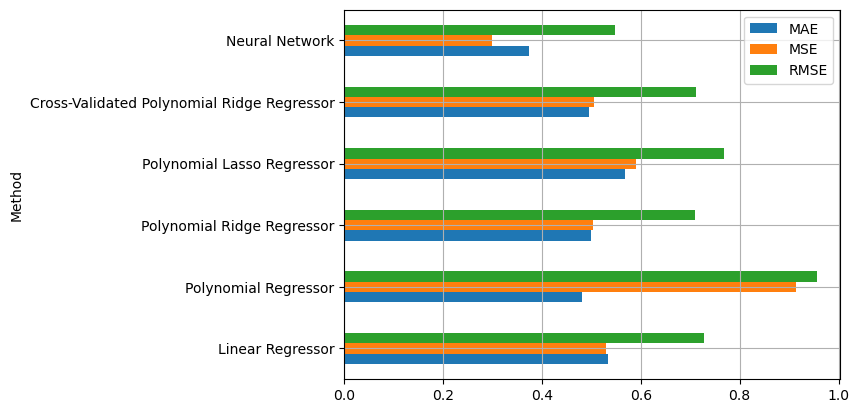

In [94]:
california_housing_val_results.plot.barh(x='Method')
plt.grid()
plt.show()

From the analysis of the validation performance, it is clear that the neural network performs better. We can now compute the final performance on the test set:

In [96]:
y_test_pred = mlp_regressor.predict(X_test)
mae, mse, rmse = mean_absolute_error(y_test, y_test_pred), mean_squared_error(y_test, y_test_pred), np.sqrt(mean_squared_error(y_test, y_test_pred))
mae, mse, rmse

(0.36642891489228313, 0.29069957110102324, np.float64(0.5391656249252388))

## References

* Chapter 3 of \[1\]
* Parts of chapter 11 of \[2\]

\[1\] Heumann, Christian, and Michael Schomaker Shalabh. Introduction to statistics and data analysis. Springer International Publishing Switzerland, 2016.

\[2\] James, Gareth Gareth Michael. An introduction to statistical learning: with applications in Python, 2023.https://www.statlearning.com